In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn torch prometheus_client prometheus_api prometheus-api-client tsts


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product

from prometheus_api_client import PrometheusConnect
from prometheus_api_client.metric_range_df import MetricRangeDataFrame
from prometheus_api_client.utils import parse_datetime

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#from tsts.models import Transformer
#from tsts.utils import TimeSeriesTensor

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# Load the dataset
file_path = '../../data/ts.pkl'  # Replace with the actual path to your ts.pkl file
df = pd.read_pickle(file_path)
df = df['value'].astype(float).resample('1T').mean().fillna(method='ffill')

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.values.reshape(-1, 1))

# Create sequences
SEQ_LENGTH = 60
X, y = [], []
for i in range(len(df_scaled) - SEQ_LENGTH):
    X.append(df_scaled[i:i + SEQ_LENGTH])
    y.append(df_scaled[i + SEQ_LENGTH])

X = np.array(X)
y = np.array(y)

/var/folders/gy/zkhvdwvx2935pz_g9lj11w840000gn/T/ipykernel_43796/1194722622.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df['value'].astype(float).resample('1T').mean().fillna(method='ffill')
/var/folders/gy/zkhvdwvx2935pz_g9lj11w840000gn/T/ipykernel_43796/1194722622.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df['value'].astype(float).resample('1T').mean().fillna(method='ffill')


In [4]:
# Expand feature dimension to match 'd_model'
d_model = 64
X = np.repeat(X, d_model, axis=2)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the Transformer Encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward):
        super(Encoder, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = src.permute(1, 0, 2)
        output = self.transformer_encoder(src)
        output = self.linear_out(output[-1])
        return output

# Hyperparameters to tune
learning_rates = [0.001, 0.01, 0.1]
num_layers_list = [2, 3, 4]

# Other fixed hyperparameters
input_dim = d_model
nhead = 4
dim_feedforward = 256
batch_size = 64
num_epochs = 10

# Function to run the training loop for a given set of hyperparameters
def train_model(learning_rate, num_layers):
    # Initialize model, loss, and optimizer with the given hyperparameters
    model = Encoder(input_dim, d_model, nhead, num_layers, dim_feedforward)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

# Initialize the best MAE and RMSE to infinity and the best hyperparameters to None
best_mae = float('inf')
best_rmse = float('inf')
best_hyperparams = None
best_model = None

# Grid search
for learning_rate, num_layers in product(learning_rates, num_layers_list):
    model = train_model(learning_rate, num_layers)
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    
    # Rescale the predicted values
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    
    print(f'Learning Rate: {learning_rate}, Num Layers: {num_layers}, MAE: {mae}, RMSE: {rmse}')
    
    # Update the best MAE and RMSE and best hyperparameters if needed
    if mae < best_mae:
        best_mae = mae
        best_rmse = rmse
        best_hyperparams = {'learning_rate': learning_rate, 'num_layers': num_layers}
        best_model = model

print(f'Best Hyperparameters: {best_hyperparams}, Best MAE: {best_mae}, Best RMSE: {best_rmse}')


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 2, MAE: 9348089.17729222, RMSE: 20892374.81206421


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 3, MAE: 9479891.333256815, RMSE: 20838556.10492311


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.001, Num Layers: 4, MAE: 8849696.83155442, RMSE: 20313111.95428781


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 2, MAE: 14308298.228476344, RMSE: 25969479.931195118


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 3, MAE: 60025536.401296176, RMSE: 73217374.10374409


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.01, Num Layers: 4, MAE: 60381682.06293966, RMSE: 73325529.61702085


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.1, Num Layers: 2, MAE: 60375871.26759909, RMSE: 73326003.28212456


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.1, Num Layers: 3, MAE: 60631076.719117574, RMSE: 73434196.39971106


/Users/wrosalem/Documents/0x0-Coding/GitHub/dissertacao/Experiments/src/2025/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Learning Rate: 0.1, Num Layers: 4, MAE: 60691626.62786911, RMSE: 73477950.47132161
Best Hyperparameters: {'learning_rate': 0.001, 'num_layers': 4}, Best MAE: 8849696.83155442, Best RMSE: 20313111.95428781


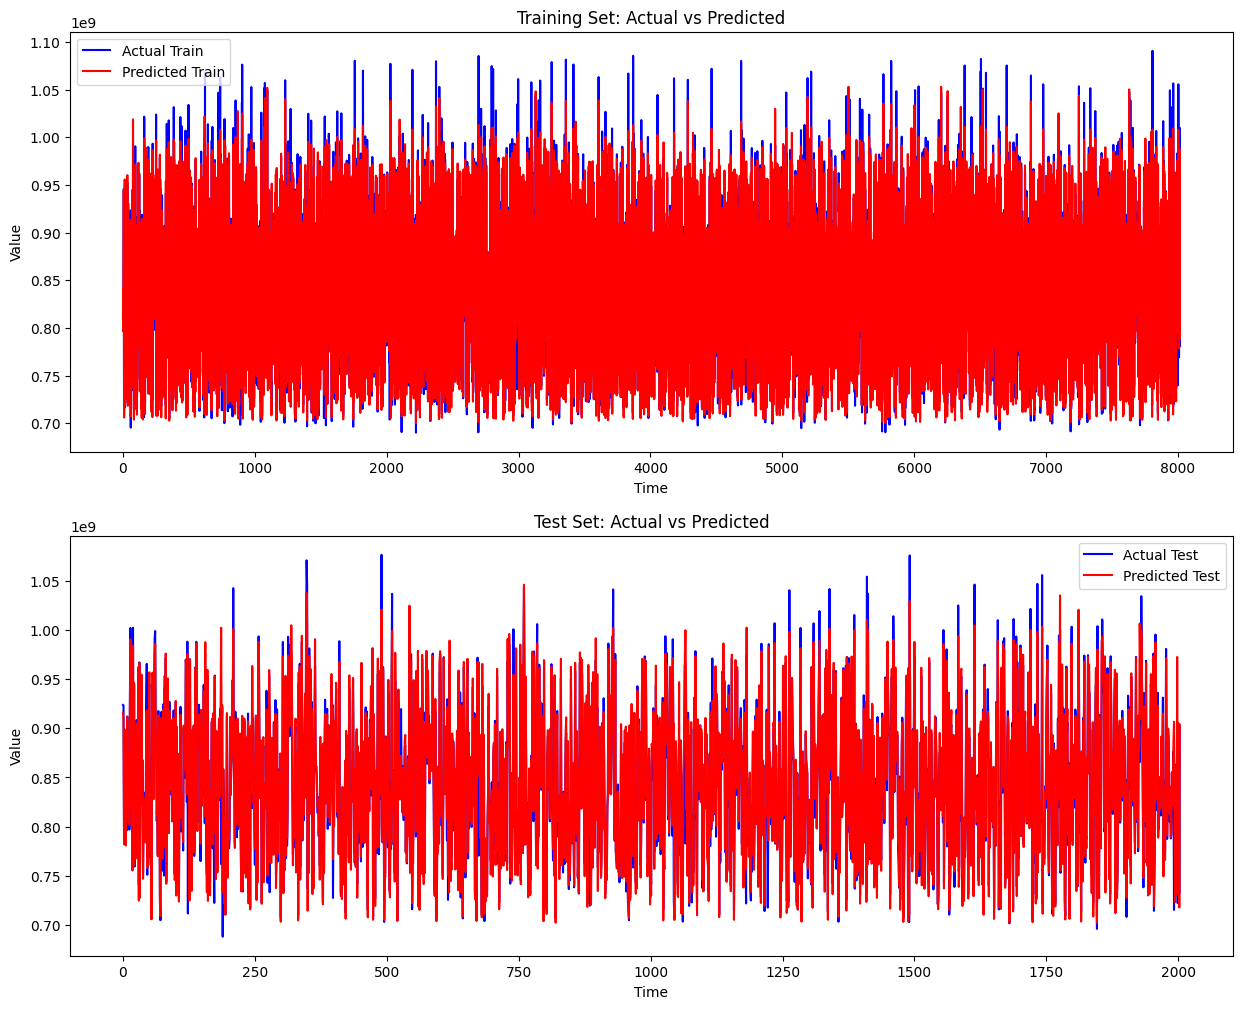

In [5]:

# Plotting
model = best_model
model.eval()

# Predictions on training set
with torch.no_grad():
    y_train_pred = model(X_train)
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_train_rescaled = scaler.inverse_transform(y_train)

# Predictions on test set
with torch.no_grad():
    y_test_pred = model(X_test)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Plot training set predictions
ax[0].plot(y_train_rescaled, label='Actual Train', color='blue')
ax[0].plot(y_train_pred_rescaled, label='Predicted Train', color='red')
ax[0].set_title('Training Set: Actual vs Predicted')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Value')
ax[0].legend()

# Plot test set predictions
ax[1].plot(y_test_rescaled, label='Actual Test', color='blue')
ax[1].plot(y_test_pred_rescaled, label='Predicted Test', color='red')
ax[1].set_title('Test Set: Actual vs Predicted')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Value')
ax[1].legend()

plt.show()